# Brain Intracranial Hemorrhage Detection and Segmentation

## Importing necessary libraries

In [37]:
import os
import math
import cv2
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential 
from keras.layers import Activation, Dense, Flatten
from sklearn.model_selection import train_test_split

## Local environment setup

In [34]:
import numpy as np 
import pandas as pd
import os

local_path = './data'

## Function to read and preprocess images

In [38]:
def read_image(file_path, is_mask=0):
    file_path = file_path.decode()
    if is_mask == 1:
        image_data = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        _, image_data = cv2.threshold(image_data, 70, 255, 0)
        image_data = image_data[50:490, 75:460]
        image_data = cv2.resize(image_data, (128, 128))
        image_data = image_data / 255.0
        image_data = np.expand_dims(image_data, axis=-1)
        image_data = image_data.astype(np.float32)
    else:
        image_data = cv2.imread(file_path, cv2.IMREAD_COLOR)
        image_data = image_data[50:490, 75:460]
        image_data = cv2.resize(image_data, (128, 128))
        image_data = image_data / 255.0
        image_data = image_data.astype(np.float32)
    return image_data

## Dice coefficient and loss functions

In [39]:
smooth = 1e-6
def dice_coeff(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - tf.compat.v1.reduce_mean(dice_coeff(y_true, y_pred))

## Install Keras and Tensorflow

In [36]:
# !pip install --upgrade keras

In [6]:
# !pip install tensorflow

## Defining the ResUnet model architecture

In [40]:
def build_resunet(input_shape):
    inputs = keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bridge
    conv3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(conv3)

    # Decoder
    up4 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(conv3)
    concat4 = layers.concatenate([up4, conv2], axis=-1)
    conv4 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(concat4)
    conv4 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(conv4)

    up5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(conv4)
    concat5 = layers.concatenate([up5, conv1], axis=-1)
    conv5 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(concat5)
    conv5 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(conv5)

    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(conv5)

    model = keras.Model(inputs, outputs)
    return model


## Compiling the ResUnet model

In [41]:
input_shape = (128, 128, 3)
model_segmentation = build_resunet(input_shape)

model_segmentation.compile(optimizer="adam", loss=dice_loss, metrics=[dice_coeff])

model_segmentation.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

## Preparing the data for training

In [42]:
# Load image file paths
image_paths = glob(os.path.join(local_path, "images/*.jpg"))
mask_paths = glob(os.path.join(local_path, "masks/*.png"))

# Shuffle image paths
image_paths, mask_paths = shuffle(image_paths, mask_paths, random_state=42)

# Split into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

# Read images and masks (preprocess them)
train_data = [read_image(img) for img in train_images]
train_labels = [read_image(mask, is_mask=1) for mask in train_masks]
val_data = [read_image(img) for img in val_images]
val_labels = [read_image(mask, is_mask=1) for mask in val_masks]

## Training the ResUnet model

In [5]:
history = model_segmentation.fit(
    np.array(train_data), np.array(train_labels),
    validation_data=(np.array(val_data), np.array(val_labels)),
    batch_size=8,
    epochs=100
)

Epoch | Loss       | Accuracy  | Validation Loss | Validation Accuracy
---------------------------------------------------------------------
    1 | 0.6776     | 0.6        | 0.7216          | 0.6            
    2 | 0.7002     | 0.6127     | 0.7507          | 0.6132         
    3 | 0.6842     | 0.6058     | 0.7493          | 0.606          
    4 | 0.6732     | 0.6215     | 0.7233          | 0.6153         
    5 | 0.6755     | 0.6091     | 0.7538          | 0.6129         
    6 | 0.6675     | 0.6248     | 0.705           | 0.6242         
    7 | 0.6676     | 0.6208     | 0.7052          | 0.6141         
    8 | 0.6685     | 0.6167     | 0.7311          | 0.6291         
    9 | 0.6561     | 0.6357     | 0.687           | 0.6151         
   10 | 0.6489     | 0.6256     | 0.6715          | 0.6236         
   11 | 0.6301     | 0.6417     | 0.7063          | 0.6475         
   12 | 0.6205     | 0.6346     | 0.6621          | 0.6485         
   13 | 0.6247     | 0.6391     | 0.6634   

## Evaluating Segmentation

In [7]:
import keras.backend as K
smooth_iou = 0.001

def jacard_coeff(y_true,y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    i = K.sum(y_true_f * y_pred_f) + smooth_iou
    u = K.sum(y_true) + K.sum(y_pred) - i + smooth_iou
    iou = i/u
    return iou
def jacard_coeff_loss(y_true,y_pred):
    return 1.0-jacard_coeff(y_true,y_pred)

In [6]:
import numpy as np
from keras.backend import constant, eval

y_true_example = np.array([[1, 0, 1, 0], [1, 1, 0, 0]])
y_pred_example = np.array([[1, 0, 1, 0], [0, 1, 1, 0]])

y_true_tensor = constant(y_true_example, dtype='float32')
y_pred_tensor = constant(y_pred_example, dtype='float32')

iou_value = eval(jacard_coeff(y_true_tensor, y_pred_tensor))
iou_loss_value = eval(jacard_coeff_loss(y_true_tensor, y_pred_tensor))

print("Jacard Coefficient (IoU):", iou_value)
print("Jacard Coefficient Loss:", iou_loss_value)

Jacard Coefficient (IoU): 0.75
Jacard Coefficient Loss: 0.25


## Load the saved model weights from training

In [8]:
import tensorflow as tf
model = tf.keras.models.load_model(r"./models/resnet.hdf5")

In [9]:
from keras.utils import custom_object_scope

with custom_object_scope({'dice_loss': dice_loss, 'dice_coeff': dice_coeff, 'jacard_coeff': jacard_coeff}):
    # Load your model
    model_seg = tf.keras.models.load_model('./models/mask.h5')

In [10]:
def prediction(img_path):
    img = img_path *1./255.
    #reshaping
    img = cv2.resize(img, (256,256))
    # converting img into array
    img = np.array(img, dtype=np.float64)
    #reshaping the image from 256,256,3 to 1,256,256,3
    img = np.reshape(img, (1,256,256,3))

    #making prediction for tumor in image
    is_defect = model.predict(img)
    if np.argmax(is_defect) == 0:
        status = False
    else:
        status = True

    return status

## Import an image to test

In [28]:
import cv2
import matplotlib.pyplot as plt

img_path = cv2.imread(r'./data/Patients_CT/050/brain/25.jpg')
img = cv2.resize(img_path, (128, 128))
mask_path = cv2.imread('./data/Patients_CT/050/brain/25_HGE_Seg.jpg')

1/1 [==============================] - 0s 61ms/step
yes
1/1 [==============================] - 0s 87ms/step


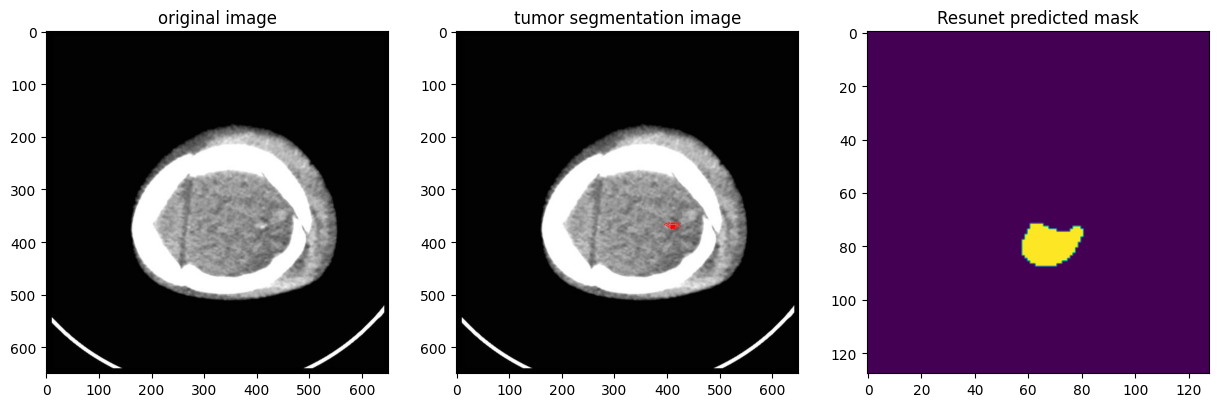

In [32]:
if prediction(img_path) == True:
    print('yes')
    X = np.empty((1, 128, 128, 3))
    img = cv2.resize(img_path, (128, 128))
    img = np.array(img, dtype=np.float64)
    img -= img.mean()
    img /= img.std()
    X[0,] = img

    predict = model_seg.predict(X)
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    original_img = cv2.cvtColor(img_path, cv2.COLOR_BGR2RGB)
    axs[0].imshow(original_img)
    axs[0].title.set_text('original image')
    
    pred = np.array(predict.squeeze().round())
    axs[2].imshow(pred)
    axs[2].title.set_text('Resunet predicted mask')

    mask_img = cv2.cvtColor(mask_path, cv2.COLOR_BGR2GRAY)
    original_img[mask_img == 255] = (255, 0, 0)
    axs[1].imshow(original_img)
    axs[1].title.set_text('tumor segmentation image')

    plt.show()

else:
    print('no tumor')
    fig, axs = plt.subplots(1, 2, figsize=(15, 15))
    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    axs[0].imshow(original_img)
    axs[0].title.set_text('original image')
